In [ ]:
!pip install rdkit
!pip install mordred
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 29.5 MB 24.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 128 kB 6.8 MB/s 
  Created wheel for mordred: filename=mordred-1.2.0-py3-none-any.whl size=176725 sha256=4898f2846d3c978be2a408366c8a311c309a11d63ee2a288e94a0d6df3b9ff75
  Stored in directory: /root/.cache/pip/wheels/02/c0/2e/e7e3d63b431777712ebc128bc4deb9ac5cb19afc7c1ea341ec
Successfully built mordred
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 10.8 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem
from collections import defaultdict
from tqdm import tqdm
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Draw

In [ ]:
from IPython.display import SVG
from IPython.display import HTML
from IPython.display import display

import rdkit
from rdkit import Chem, rdBase, DataStructs
from rdkit.Chem import rdmolfiles, rdmolops, AllChem, Draw, rdDepictor, Descriptors
from rdkit.Chem.Draw import IPythonConsole, rdMolDraw2D
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem.Fingerprints import FingerprintMols

In [ ]:
class Morgan_fingerprint(): #From Chen

    def __init__(self,mols):
        self.mols = mols
        self.bitExamples = {}
        self.keepMols = {}
        return
    
    def calculate(self,radius=2,bits=1024,vector_type="count",unhash=False):
        if vector_type not in ["count","bit"]: 
            return
        elif vector_type=="bit":
            unhash=False
            fp_all = defaultdict()
            
        mols = self.mols
        self.bits = bits
        self.radius = radius
        self.bitI_morgan =  {}
        morgan_count = defaultdict(lambda:[0]*len(mols))
        for idx,mol in enumerate(tqdm(mols)):
            self.bitI_morgan[idx] = {}
            if unhash==True:
                fp_morgan = AllChem.GetMorganFingerprint(mol, radius, bitInfo=self.bitI_morgan[idx])
            else:
                fp_morgan = AllChem.GetMorganFingerprintAsBitVect(mol, radius, 
                                                                  bitInfo=self.bitI_morgan[idx],nBits=bits)
                if vector_type=="bit":
                    arr = np.zeros((1,))
                    DataStructs.ConvertToNumpyArray(fp_morgan, arr)
                    fp_all[idx]= arr
            for key in list(self.bitI_morgan[idx].keys()):
                morgan_count["{}".format(key)][idx]=len(self.bitI_morgan[idx][key])
                #generate bit examples for visualization
                self.bitExamples[key] = idx
                self.keepMols[idx]=mol
                
        if vector_type=="bit": return pd.DataFrame.from_dict(fp_all).T #Bit type       
        return pd.DataFrame.from_dict(morgan_count)

    def visualize(self,bit_name,molSize=(250,200),verbose=True):
        bitId = int(bit_name)
        if verbose==True: print ('bit %s'%bitId)
        zid = self.bitExamples[bitId]
        mol = self.keepMols[zid]
        aid,rad = self.bitI_morgan[zid][bitId][0]
        pic1,svg  = getSubstructDepiction(mol,aid,rad,molSize=molSize)
        pic2 = Draw.DrawMorganBit(mol,bitId,self.bitI_morgan[zid])
        #display(pic)
        return pic1,pic2,svg

#for visualization #From Chen
def _prepareMol(mol,kekulize):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    return mc

def moltosvg(mol,molSize=(450,200),kekulize=True,drawer=None,**kwargs):
    mc = _prepareMol(mol,kekulize)
    if drawer is None:
        drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    drawer.DrawMolecule(mc,**kwargs)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    # It seems that the svg renderer used doesn't quite hit the spec.
    # Here are some fixes to make it work in the notebook, although I think
    # the underlying issue needs to be resolved at the generation step
    #with open('morgan bits/%s.svg'%bitId, 'w') as f:
    #    f.write(svg)
    return SVG(svg.replace('svg:','')),svg 

def getSubstructDepiction(mol,atomID,radius,molSize=(450,200)):
    if radius>0:
        env = Chem.FindAtomEnvironmentOfRadiusN(mol,radius,atomID)
        atomsToUse=[]
        for b in env:
            atomsToUse.append(mol.GetBondWithIdx(b).GetBeginAtomIdx())
            atomsToUse.append(mol.GetBondWithIdx(b).GetEndAtomIdx())
        atomsToUse = list(set(atomsToUse))       
    else:
        atomsToUse = [atomID]
        env=None
    return moltosvg(mol,molSize=molSize,highlightAtoms=atomsToUse)

#MACCS Keys Fingerprints
def maccskeys_fingerprint(mols):
  maccs_fps = [AllChem.GetMACCSKeysFingerprint(mol) for mol in mols]
  df_maccs = pd.DataFrame(np.array(maccs_fps, int))
  return df_maccs

#RDKit Descriptors
def rdkit_descriptor(mols):
  from rdkit.ML.Descriptors import MoleculeDescriptors
  from rdkit.Chem import  Descriptors
  descriptor_names = [name[0] for name in Descriptors.descList]
  descriptor_calculator = MoleculeDescriptors.MolecularDescriptorCalculator(descriptor_names)
  desc = [descriptor_calculator.CalcDescriptors(mol) for mol in mols]
  df_RDKit = pd.DataFrame(desc, columns=descriptor_names)
  return df_RDKit

#RDKit Fingerprints
def rdkit_fingerprint(mols):
  fp = [AllChem.RDKFingerprint(mol) for mol in mols]
  df_fp = pd.DataFrame(np.array(fp, int))
  return df_fp

#Mordred Descriptors
def mordred_descriptor(mols, ignore_3D=True):
  from mordred import Calculator, descriptors
  calc = Calculator(descriptors, ignore_3D=True)
  df_mordred = calc.pandas(mols)
  df_mordred = df_mordred.astype(float) #Mordred descriptor contains missing values, so need to change type to float.
  return df_mordred

In [ ]:
# A list for the evaluation result
r2_sum = pd.DataFrame()
rmse_sum = pd.DataFrame()

# **MACCS Keys Fingerprints**

In [ ]:
df_Cbg = pd.read_csv('./drive/MyDrive/AI/Material Informatics (MI)/Conductive polymer QSAR/Table of Supporting Information(SMILES)- Cal band gap.csv')
df_Cbg['Mols'] = df_Cbg['SMILES'].apply(lambda x : Chem.MolFromSmiles(x))
df_Cbg = df_Cbg.dropna(0)
desc_f = maccskeys_fingerprint(df_Cbg["Mols"].values)
d_desc_f = desc_f.dropna(1)

NameError: ignored

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
model = RandomForestRegressor()
rmse_list = []
y_test_group = []
y_pred_group = []

X = d_desc_f.values
y = df_Cbg.iloc[:, -3].values

for train_index, test_index in tqdm(loo.split(X)):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  y_test_group.append(y_test)
  
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  y_pred_group.append(y_pred)
  
  rmse = np.sqrt(mean_squared_error(y_test, y_pred))
  rmse_list.append(rmse)
avg_rmse = np.mean(rmse_list)
avg_rsquare = r2_score(y_test_group, y_pred_group) #List can be used for input, the array-shape should be less than 2D

print(f'Average RMSE is {avg_rmse}\tAverage R square is {avg_rsquare}')

284it [01:24,  3.38it/s]

Average RMSE is 0.29871663719818936	Average R square is 0.8463043276903459


In [ ]:
r2_sum.loc['Random Forest', 'MACCS Keys Fingerprints'] = avg_rsquare
rmse_sum.loc['Random Forest', 'MACCS Keys Fingerprints'] = avg_rmse

### Feature Importance

Text(0.5, 0, 'Feature Importance')

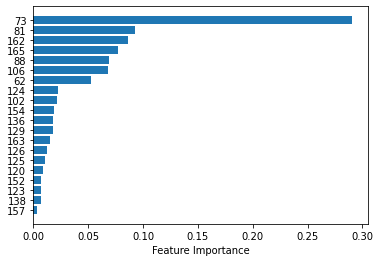

In [ ]:
sort = model.feature_importances_.argsort()
plt.barh(d_desc_f.columns[sort].astype(str)[-20:], model.feature_importances_[sort][-20:])
plt.xlabel("Feature Importance")

# **RDKit Descriptors**

In [ ]:
df_Cbg = pd.read_csv('./drive/MyDrive/AI/Material Informatics (MI)/Conductive polymer QSAR/Table of Supporting Information(SMILES)- Cal band gap.csv')
df_Cbg['Mols'] = df_Cbg['SMILES'].apply(lambda x : Chem.MolFromSmiles(x))
df_Cbg = df_Cbg.dropna(0)
desc_f = rdkit_descriptor(df_Cbg["Mols"].values)
d_desc_f = desc_f.dropna(1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  """


In [ ]:
d_desc_f.to_csv("output.csv")

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
model = RandomForestRegressor()
rmse_list = []
y_test_group = []
y_pred_group = []

X = d_desc_f.values
y = df_Cbg.iloc[:, -3].values

for train_index, test_index in tqdm(loo.split(X)):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  y_test_group.append(y_test)
  
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  y_pred_group.append(y_pred)
  
  rmse = np.sqrt(mean_squared_error(y_test, y_pred))
  rmse_list.append(rmse)
avg_rmse = np.mean(rmse_list)
avg_rsquare = r2_score(y_test_group, y_pred_group) #List can be used in R square

print(f'Average RMSE is {avg_rmse}\tAverage R square is {avg_rsquare}')

284it [04:12,  1.13it/s]

Average RMSE is 0.269567253521127	Average R square is 0.8591964515255474


In [ ]:
r2_sum.loc['Random Forest', 'RDKit Descriptors'] = avg_rsquare
rmse_sum.loc['Random Forest', 'RDKit Descriptors'] = avg_rmse

### Feature Importance

Text(0.5, 0, 'Feature Importance')

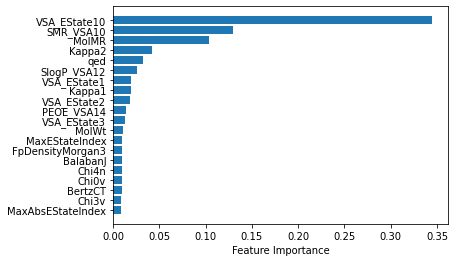

In [ ]:
sort = model.feature_importances_.argsort() #argsort returns the original index sorted based on the value
plt.barh(d_desc_f.columns[sort].astype(str)[-20:], model.feature_importances_[sort][-20:])
plt.xlabel("Feature Importance")

### Permutation Importance

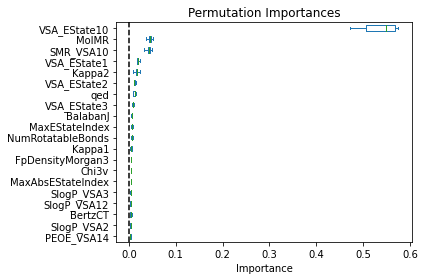

In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    model, X, y, n_repeats=10, random_state=42,)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx][-20:].T,
    columns=d_desc_f.columns[sorted_importances_idx][-20:].astype(str),
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Importance")
ax.figure.tight_layout()

### Shap

In [ ]:
# import shap

# shap.initjs()
# explainer = shap.TreeExplainer(model=model, feature_perturbation='tree_path_dependent', model_output='margin')
# shap_values = explainer.shap_values(X=d_desc_f)
# shap.summary_plot(shap_values, d_desc_f, plot_type="bar")

In [ ]:
# shap.summary_plot(shap_values, d_desc_f)

In [ ]:
# idx = 50
# shap.initjs()
# shap.force_plot(base_value=explainer.expected_value, shap_values=shap_values[100], features=d_desc_f.iloc[idx])

In [ ]:
# shap.dependence_plot(ind="VSA_EState10", shap_values=shap_values, features=d_desc_f)

# **RDKit Fingerprints**

In [ ]:
df_Cbg = pd.read_csv('./drive/MyDrive/AI/Material Informatics (MI)/Conductive polymer QSAR/Table of Supporting Information(SMILES)- Cal band gap.csv')
df_Cbg['Mols'] = df_Cbg['SMILES'].apply(lambda x : Chem.MolFromSmiles(x))
df_Cbg = df_Cbg.dropna(0)
desc_f = rdkit_fingerprint(df_Cbg["Mols"].values)
d_desc_f = desc_f.dropna(1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  """


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
model = RandomForestRegressor()
rmse_list = []
y_test_group = []
y_pred_group = []

X = d_desc_f.values
y = df_Cbg.iloc[:, -3].values

for train_index, test_index in tqdm(loo.split(X)):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  y_test_group.append(y_test)
  
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  y_pred_group.append(y_pred)
  
  rmse = np.sqrt(mean_squared_error(y_test, y_pred))
  rmse_list.append(rmse)
avg_rmse = np.mean(rmse_list)
avg_rsquare = r2_score(y_test_group, y_pred_group) #List can be used in R square

print(f'Average RMSE is {avg_rmse}\tAverage R square is {avg_rsquare}')

284it [17:24,  3.68s/it]

Average RMSE is 0.24719778169014092	Average R square is 0.8941480988560372


In [ ]:
r2_sum.loc['Random Forest', 'RDKit Fingerprints'] = avg_rsquare
rmse_sum.loc['Random Forest', 'RDKit Fingerprints'] = avg_rmse

### Feature Importance

Text(0.5, 0, 'Feature Importance')

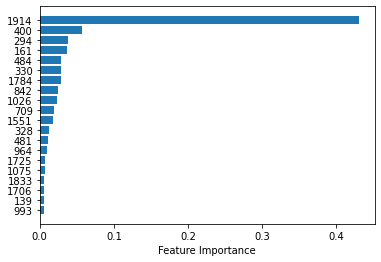

In [ ]:
sort = model.feature_importances_.argsort()
plt.barh(d_desc_f.columns[sort].astype(str)[-20:], model.feature_importances_[sort][-20:])
plt.xlabel("Feature Importance")

# **Morgan Fingerprints(radius=2)**

In [ ]:
df_Cbg = pd.read_csv('./drive/MyDrive/AI/Material Informatics (MI)/Conductive polymer QSAR/Table of Supporting Information(SMILES)- Cal band gap.csv')
df_Cbg['Mols'] = df_Cbg['SMILES'].apply(lambda x : Chem.MolFromSmiles(x))
df_Cbg = df_Cbg.dropna(0)
mf_Cbg = Morgan_fingerprint(df_Cbg["Mols"].values)
fp_Cbg = mf_Cbg.calculate(radius=2,bits=1024,vector_type="count",unhash=False)
fp_Cbg = fp_Cbg.dropna(1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until
100%|██████████| 284/284 [00:00<00:00, 10514.08it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
model = RandomForestRegressor()
rmse_list = []
y_test_group = []
y_pred_group = []

X = fp_Cbg.values
y = df_Cbg.iloc[:, -3].values

for train_index, test_index in tqdm(loo.split(X)):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  y_test_group.append(y_test)
  
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  y_pred_group.append(y_pred)
  
  rmse = np.sqrt(mean_squared_error(y_test, y_pred))
  rmse_list.append(rmse)
avg_rmse = np.mean(rmse_list)
avg_rsquare = r2_score(y_test_group, y_pred_group) #List can be used in R square

print(f'Average RMSE is {avg_rmse}\tAverage R square is {avg_rsquare}')

284it [02:48,  1.68it/s]

Average RMSE is 0.24179496478873239	Average R square is 0.894739773047109


In [ ]:
r2_sum.loc['Random Forest', 'Morgan Fingerprints(radius=2)'] = avg_rsquare
rmse_sum.loc['Random Forest', 'Morgan Fingerprints(radius=2)'] = avg_rmse

### Feature Importance

Text(0.5, 0, 'Feature Importance')

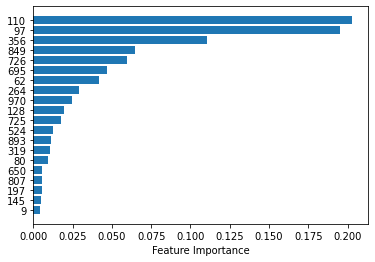

In [ ]:
sort = model.feature_importances_.argsort()
plt.barh(fp_Cbg.columns[sort].astype(str)[-20:], model.feature_importances_[sort][-20:])
plt.xlabel("Feature Importance")

bit 97


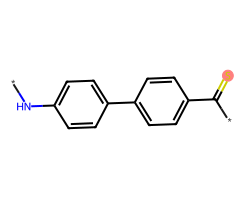

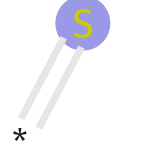

bit 110


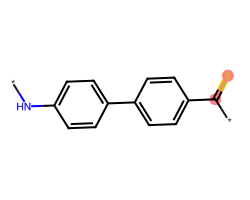

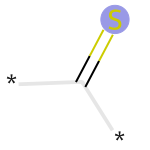

bit 356


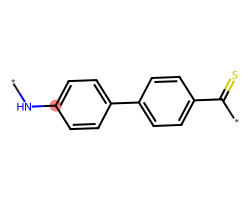

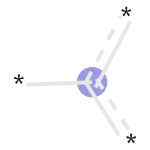

bit 849


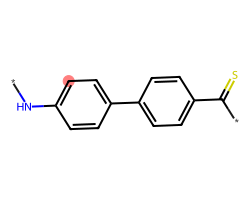

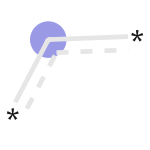

bit 726


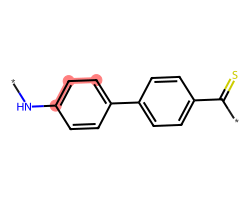

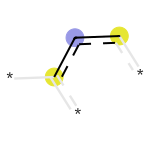

bit 695


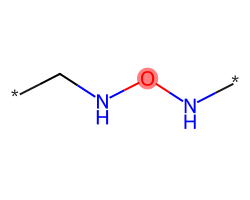

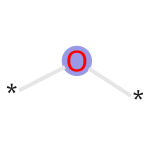

In [ ]:
from IPython.core.display import display

#check single bit
bits = [97, 110, 356, 849, 726, 695]
for bit in bits:
  pic1,pic2,_ = mf_Cbg.visualize(bit)
  display(pic1)
  display(pic2)

# **Morgan Fingerprints(radius=1)**

In [ ]:
df_Cbg = pd.read_csv('./drive/MyDrive/AI/Material Informatics (MI)/Conductive polymer QSAR/Table of Supporting Information(SMILES)- Cal band gap.csv')
df_Cbg['Mols'] = df_Cbg['SMILES'].apply(lambda x : Chem.MolFromSmiles(x))
df_Cbg = df_Cbg.dropna(0)
mf_Cbg = Morgan_fingerprint(df_Cbg["Mols"].values)
fp_Cbg = mf_Cbg.calculate(radius=1,bits=1024,vector_type="count",unhash=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until
100%|██████████| 284/284 [00:00<00:00, 17142.52it/s]


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
model = RandomForestRegressor()
rmse_list = []
y_test_group = []
y_pred_group = []

X = d_desc_f.values
y = df_Cbg.iloc[:, -3].values

for train_index, test_index in tqdm(loo.split(X)):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  y_test_group.append(y_test)
  
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  y_pred_group.append(y_pred)
  
  rmse = np.sqrt(mean_squared_error(y_test, y_pred))
  rmse_list.append(rmse)
avg_rmse = np.mean(rmse_list)
avg_rsquare = r2_score(y_test_group, y_pred_group) #List can be used in R square

print(f'Average RMSE is {avg_rmse}\tAverage R square is {avg_rsquare}')

284it [17:22,  3.67s/it]

Average RMSE is 0.24555936619718316	Average R square is 0.8975502491493137


In [ ]:
r2_sum.loc['Random Forest', 'Morgan Fingerprints(radius=1)'] = avg_rsquare
rmse_sum.loc['Random Forest', 'Morgan Fingerprints(radius=1)'] = avg_rmse

### Feature Importance

Text(0.5, 0, 'Feature Importance')

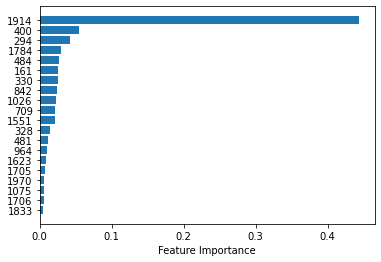

In [ ]:
sort = model.feature_importances_.argsort()
plt.barh(d_desc_f.columns[sort].astype(str)[-20:], model.feature_importances_[sort][-20:])
plt.xlabel("Feature Importance")

# **Morgan Fingerprints(radius=3)**



In [ ]:
df_Cbg = pd.read_csv('./drive/MyDrive/AI/Material Informatics (MI)/Conductive polymer QSAR/Table of Supporting Information(SMILES)- Cal band gap.csv')
df_Cbg['Mols'] = df_Cbg['SMILES'].apply(lambda x : Chem.MolFromSmiles(x))
df_Cbg = df_Cbg.dropna(0)
mf_Cbg = Morgan_fingerprint(df_Cbg["Mols"].values)
fp_Cbg = mf_Cbg.calculate(radius=3,bits=1024,vector_type="count",unhash=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until
100%|██████████| 284/284 [00:00<00:00, 9597.33it/s]


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
model = RandomForestRegressor()
rmse_list = []
y_test_group = []
y_pred_group = []

X = d_desc_f.values
y = df_Cbg.iloc[:, -3].values

for train_index, test_index in tqdm(loo.split(X)):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  y_test_group.append(y_test)
  
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  y_pred_group.append(y_pred)
  
  rmse = np.sqrt(mean_squared_error(y_test, y_pred))
  rmse_list.append(rmse)
avg_rmse = np.mean(rmse_list)
avg_rsquare = r2_score(y_test_group, y_pred_group) #List can be used in R square

print(f'Average RMSE is {avg_rmse}\tAverage R square is {avg_rsquare}')

284it [17:20,  3.66s/it]

Average RMSE is 0.24967246478873256	Average R square is 0.8950804927863069


In [ ]:
r2_sum.loc['Random Forest', 'Morgan Fingerprints(radius=3)'] = avg_rsquare
rmse_sum.loc['Random Forest', 'Morgan Fingerprints(radius=3)'] = avg_rmse

### Feature Importance

Text(0.5, 0, 'Feature Importance')

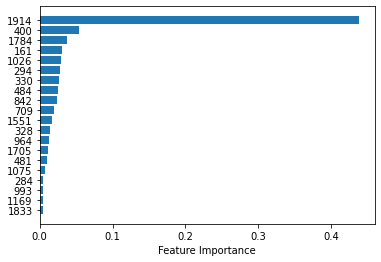

In [ ]:
sort = model.feature_importances_.argsort()
plt.barh(d_desc_f.columns[sort].astype(str)[-20:], model.feature_importances_[sort][-20:])
plt.xlabel("Feature Importance")

# **Mordred Descriptors**

In [ ]:
df_Cbg = pd.read_csv('./drive/MyDrive/AI/Material Informatics (MI)/Conductive polymer QSAR/Table of Supporting Information(SMILES)- Cal band gap.csv')
df_Cbg['Mols'] = df_Cbg['SMILES'].apply(lambda x : Chem.MolFromSmiles(x))
df_Cbg = df_Cbg.dropna(0)
desc_f = mordred_descriptor(df_Cbg["Mols"].values)
d_desc_f = desc_f.dropna(1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until
100%|██████████| 284/284 [01:02<00:00,  4.52it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  """


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
model = RandomForestRegressor()
rmse_list = []
y_test_group = []
y_pred_group = []

X = d_desc_f.values
y = df_Cbg.iloc[:, -3].values

for train_index, test_index in tqdm(loo.split(X)):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  y_test_group.append(y_test)
  
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  y_pred_group.append(y_pred)
  
  rmse = np.sqrt(mean_squared_error(y_test, y_pred))
  rmse_list.append(rmse)
avg_rmse = np.mean(rmse_list)
avg_rsquare = r2_score(y_test_group, y_pred_group) #List can be used in R square

print(f'Average RMSE is {avg_rmse}\tAverage R square is {avg_rsquare}')

284it [14:39,  3.10s/it]

Average RMSE is 0.26493035211267624	Average R square is 0.8632198273292191


In [ ]:
r2_sum.loc['Random Forest', 'Mordred Descriptors'] = avg_rsquare
rmse_sum.loc['Random Forest', 'Mordred Descriptors'] = avg_rmse

### Feature Importance

Text(0.5, 0, 'Feature Importance')

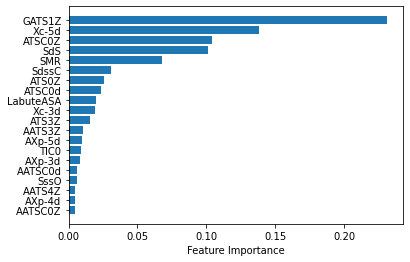

In [ ]:
sort = model.feature_importances_.argsort()
plt.barh(d_desc_f.columns[sort].astype(str)[-20:], model.feature_importances_[sort][-20:])
plt.xlabel("Feature Importance")

# **Model Evaluation**

In [ ]:
r2_sum

,MACCS Keys Fingerprints,RDKit Descriptors,RDKit Fingerprints,Morgan Fingerprints(radius=2),Morgan Fingerprints(radius=1),Morgan Fingerprints(radius=3),Mordred Descriptors
Random Forest,0.846304,0.862292,0.894148,0.89474,0.89755,0.89508,0.86322


In [ ]:
rmse_sum

,MACCS Keys Fingerprints,RDKit Descriptors,RDKit Fingerprints,Morgan Fingerprints(radius=2),Morgan Fingerprints(radius=1),Morgan Fingerprints(radius=3),Mordred Descriptors
Random Forest,0.298717,0.267597,0.247198,0.241795,0.245559,0.249672,0.26493
